# 

In [1]:
!pip install datasets transformers peft trl evaluate accelerate bitsandbytes --quiet


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# 1. Load các thư viện cần thiết
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [3]:
# 2. Load dữ liệu VietNews
dataset = load_dataset("harouzie/vietnews", split="train")
df = pd.DataFrame(dataset)

Generating train split:   0%|          | 0/99134 [00:00<?, ? examples/s]

Generating train split:   5%|▌         | 5000/99134 [00:00<00:02, 44081.06 examples/s]

Generating train split:  14%|█▍        | 14000/99134 [00:00<00:01, 66965.26 examples/s]

Generating train split:  25%|██▌       | 25000/99134 [00:00<00:00, 77625.23 examples/s]

Generating train split:  36%|███▋      | 36000/99134 [00:00<00:00, 87427.65 examples/s]

Generating train split:  48%|████▊     | 48000/99134 [00:00<00:00, 96204.96 examples/s]

Generating train split:  60%|█████▉    | 59000/99134 [00:00<00:00, 96837.62 examples/s]

Generating train split:  72%|███████▏  | 71000/99134 [00:00<00:00, 97710.28 examples/s]

Generating train split:  82%|████████▏ | 81000/99134 [00:00<00:00, 91673.08 examples/s]

Generating train split:  96%|█████████▌| 95000/99134 [00:01<00:00, 101200.14 examples/s]

Generating train split: 100%|██████████| 99134/99134 [00:01<00:00, 92448.69 examples/s] 

Generating validation split:   0%|          | 0/22184 [00:00<?, ? examples/s]

Generating validation split:  36%|███▌      | 8000/22184 [00:00<00:00, 74549.33 examples/s]

Generating validation split:  90%|█████████ | 20000/22184 [00:00<00:00, 95143.64 examples/s]

Generating validation split: 100%|██████████| 22184/22184 [00:00<00:00, 95302.54 examples/s]

Generating test split:   0%|          | 0/22498 [00:00<?, ? examples/s]

Generating test split:  36%|███▌      | 8000/22498 [00:00<00:00, 75289.02 examples/s]

Generating test split:  89%|████████▉ | 20000/22498 [00:00<00:00, 96977.81 examples/s]

Generating test split: 100%|██████████| 22498/22498 [00:00<00:00, 97742.10 examples/s]

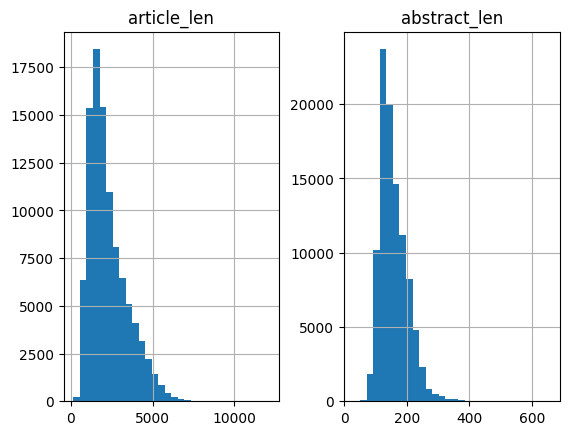

In [4]:
# 3. Phân tích độ dài văn bản
df['article_len'] = df['article'].str.len()
df['abstract_len'] = df['abstract'].str.len()

df[['article_len', 'abstract_len']].hist(bins=30)
plt.show()

In [5]:
# 4. Tiền xử lý: lọc văn bản quá ngắn hoặc quá dài
df = df[(df['article_len'] > 300) & (df['article_len'] < 3000)]

In [6]:
# 5. Tạo định dạng instruction-style cho QLoRA
def format_example(row):
    return {
        "instruction": "Tóm tắt bài báo sau bằng tiếng Việt:",
        "input": row["article"],
        "output": row["abstract"]
    }

formatted = df.apply(format_example, axis=1)
formatted_ds = pd.DataFrame(formatted.tolist())

In [7]:
# 6. Chia train / val
train_df, val_df = train_test_split(formatted_ds, test_size=0.05, random_state=42)

In [8]:
# 7. Save to disk để dùng huấn luyện
train_df.to_json("train.json", orient="records", lines=True, force_ascii=False)
val_df.to_json("val.json", orient="records", lines=True, force_ascii=False)

In [9]:
# 8. Huấn luyện QLoRA với VietAI/vit5-small
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import load_dataset
import torch

# ✅ Dùng mô hình công khai ổn định
model_name = "VietAI/vit5-base"

# Tải model dạng 4-bit QLoRA
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

# ✅ Chuẩn bị QLoRA
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)

E0000 00:00:1748566300.332863      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


None of the available devices `available_devices = None` are supported by the bitsandbytes version you have installed: `bnb_supported_devices = {'npu', 'cuda', 'mps', 'hpu', 'xpu', '"cpu" (needs an Intel CPU and intel_extension_for_pytorch installed and compatible with the PyTorch version)'}`. Please check the docs to see if the backend you intend to use is available and how to install it: https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


RuntimeError: None of the available devices `available_devices = None` are supported by the bitsandbytes version you have installed: `bnb_supported_devices = {'npu', 'cuda', 'mps', 'hpu', 'xpu', '"cpu" (needs an Intel CPU and intel_extension_for_pytorch installed and compatible with the PyTorch version)'}`. Please check the docs to see if the backend you intend to use is available and how to install it: https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend

In [ ]:
# 9. Load lại tập train/val từ JSON đã lưu
train_ds = load_dataset("json", data_files="train.json", split="train")
val_ds = load_dataset("json", data_files="val.json", split="train")

In [ ]:
# 10. Tiền xử lý (tokenize)
def preprocess(batch):
    inputs = [i + "\n" + x for i, x in zip(batch["instruction"], batch["input"])]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["output"], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# ✅ Tiến hành token hóa
train_tokenized = train_ds.map(preprocess, batched=True)
val_tokenized = val_ds.map(preprocess, batched=True)


In [ ]:
import transformers
print(transformers.__version__)  # >= 4.25.1 là ổn


In [ ]:
# 11. Cấu hình huấn luyện QLoRA

from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

training_args = Seq2SeqTrainingArguments(
    output_dir="./vit5-vietnews-qlora",
    num_train_epochs=5,                                
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    fp16=True,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=10,
    report_to="none",
    label_names=["labels"]
)


data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    # tokenizer=tokenizer,
    data_collator=data_collator
)


In [ ]:
trainer.train()

In [ ]:
!zip -r vit5_qlora_model.zip vit5-vietnews-qlora/checkpoint-13000

In [ ]:
!pip install transformers peft datasets rouge-score --quiet

In [ ]:
# 12. Load model ở checkpoint 13440 với training loss thấp nhất
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel
import torch

# Load base model từ Hugging Face (hoặc từ local nếu đã tải về)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    "VietAI/vit5-base", 
    device_map="auto"
)

# Load adapter đã fine-tune bằng QLoRA
model = PeftModel.from_pretrained(
    base_model,
    "./vit5-vietnews-qlora/checkpoint-13000",  
    is_trainable=False
)

# Load tokenizer tương ứng
tokenizer = AutoTokenizer.from_pretrained(
    "VietAI/vit5-base",  
    use_fast=False
)

model.eval()

In [ ]:
# text = "Thủ tướng cho biết Việt Nam sẽ tăng đầu tư cho khoa học công nghệ trong năm tới..."
text = "Thủ tướng Phạm Minh Chính khẳng định Chính phủ sẽ ưu tiên phát triển hạ tầng giao thông trọng điểm trong năm 2025."
prompt = "Tóm tắt bài báo sau bằng tiếng Việt: " + text

inputs = tokenizer(sum_text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
output = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(output[0], skip_special_tokens=True))



In [ ]:
def summarize(text: str, max_tokens=128):
    instruction = "Tóm tắt bài báo sau bằng tiếng Việt: "
    input_text = instruction + text
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)


    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7,
            top_p=0.95,
            top_k=50
        )

    return tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
sum_text = """
Chiều 28/5, tại Hà Nội, Bộ Giáo dục và Đào tạo tổ chức hội thảo lấy ý kiến chuyên gia về đề xuất sửa đổi Luật Giáo dục năm 2005. Trong đó, nhiều chuyên gia cho rằng cần thay đổi cách tính học phí và đảm bảo quyền lợi cho giáo viên, học sinh...
"""


print("📄 Tóm tắt:", summarize(sum_text))
